<a href="https://colab.research.google.com/github/alexv710/debias_cv_data/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import os
import datetime

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

# sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Data Preprocessing

In [2]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 

data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data

data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16'])

# Remove sampling weights (within and out of the experiment)

data = data.drop(columns='POIDS_SEL')

# Remove all the centered features

data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data

data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

# clean up dataset nan values
# print(len(data))
# for item in data:
    # if data[item].isna().sum() > 0:
        # print(item, data[item].isna().sum())
        
data.dropna(subset=['CV_note_7p', 'etudes_etranger', 'langue_anglais'],inplace=True)

# print(len(data))
# for item in data:
    # if data[item].isna().sum() > 0:
        # print(item, data[item].isna().sum())

# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function

data = min_max_scaling(data)

In [3]:
# Create a dataframe for the anonymized and not anonymized data

X_ano = pd.DataFrame()
X_unano = pd.DataFrame()
X = pd.DataFrame()

for index, row in data.iterrows():
  if row['CVA'] == 1: 
    X_ano = X_ano.append(row)
  else:
    X_unano = X_unano.append(row)

# Assign the interviewed column to our target vector

y_ano = X_ano['ENTRETIEN']
y_unano = X_unano['ENTRETIEN']
y = data['ENTRETIEN']

# Drop the Interviewed/hired & anonymized columns (hired is much dependend on the number of jobs available
# and will currently not be considered as target label)
X_ano = X_ano.drop(columns=['CVA'])
X_unano = X_unano.drop(columns=['CVA'])
X = data.drop(columns=['CVA'])

<AxesSubplot:>

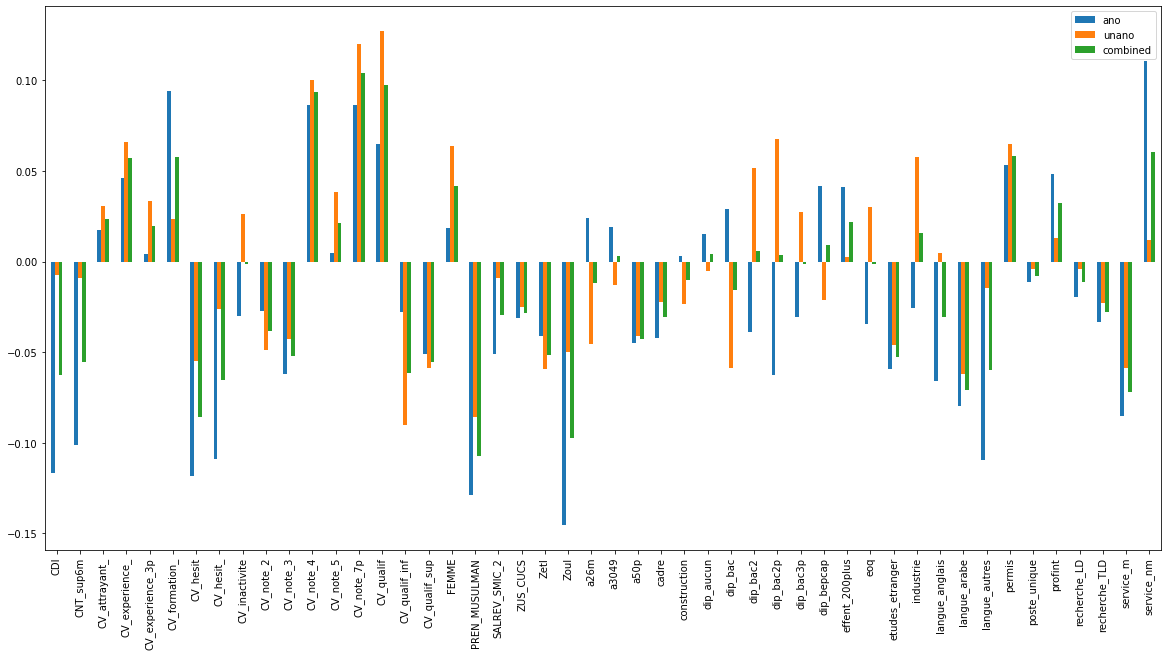

In [4]:
corrTable = pd.DataFrame()

corrTable['ano'] = X_ano.corr()['ENTRETIEN']
corrTable['unano'] = X_unano.corr()['ENTRETIEN']
corrTable['combined'] = data.corr()['ENTRETIEN']

corrTable.drop('ENTRETIEN', axis=0).plot.bar(figsize=(20,10))

In [5]:
X_ano = X_ano.drop(columns=['ENTRETIEN'])
X_unano = X_unano.drop(columns=['ENTRETIEN'])
X = X.drop(columns=['ENTRETIEN'])

### Data Preparation for models

In [6]:
# Train, Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=54)

## Random Forest

In [7]:


# define the model
modelForest = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelForest, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

modelForest.fit(X_train, y_train)

y_pred = modelForest.predict(X_test)

errors = abs(y_pred - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = sum(errors) / len(errors) * 100
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 0.858 (0.006)
Mean Absolute Error: 0.07 degrees.
Accuracy: 92.66 %.


## Support Vector Machine

In [8]:


#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred) * 100, 2), '%.')

Accuracy: 92.66 %.


# Neural Network

The neural network "simpleNet" is built using Keras with one input layer with the activation function relu and one output layer using a sigmoid activation function for binary classification. In addition three hidden layers are addedm, all with relu activation function.

In [9]:
# define the keras model

name="simpleNet"
model = keras.Sequential(
    [
        layers.Dense(48, input_dim=48, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.08)),
                
        # layers.Dropout(0.5),
        layers.Dense(24, activation='relu'),
        layers.Dense(24, activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(12, activation='relu'),
        
        layers.Dense(1, activation='sigmoid')  
    
    ],name=name
)
model.summary()

Model: "simpleNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                2352      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 4,441
Trainable params: 4,441
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras.optimizers import SGD
sgd = keras.optimizers.SGD(lr=.1, momentum=0.2, nesterov=True)


#Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.01,
                       patience=4,
                       min_lr=1e-8,
                       verbose=1)
#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",\
                                      patience=8, verbose=0, mode="auto", baseline=None, restore_best_weights=True)


model.compile(optimizer="sgd", loss="mae", metrics=["mae", 'accuracy'])

model.fit(np.array(X_train), np.array(y_train), epochs=20, callbacks=[es, lrr], validation_split=0.2, shuffle=True, verbose=2)

_, _, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
25/25 - 0s - loss: 0.4649 - mae: 0.4649 - accuracy: 0.8588 - val_loss: 0.4444 - val_mae: 0.4444 - val_accuracy: 0.8718
Epoch 2/20
25/25 - 0s - loss: 0.4265 - mae: 0.4265 - accuracy: 0.8588 - val_loss: 0.3971 - val_mae: 0.3971 - val_accuracy: 0.8718
Epoch 3/20
25/25 - 0s - loss: 0.3740 - mae: 0.3740 - accuracy: 0.8588 - val_loss: 0.3372 - val_mae: 0.3372 - val_accuracy: 0.8718
Epoch 4/20
25/25 - 0s - loss: 0.3142 - mae: 0.3142 - accuracy: 0.8588 - val_loss: 0.2753 - val_mae: 0.2753 - val_accuracy: 0.8718
Epoch 5/20

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999776482583e-05.
25/25 - 0s - loss: 0.2600 - mae: 0.2600 - accuracy: 0.8588 - val_loss: 0.2267 - val_mae: 0.2267 - val_accuracy: 0.8718
Epoch 6/20
25/25 - 0s - loss: 0.2366 - mae: 0.2366 - accuracy: 0.8588 - val_loss: 0.2263 - val_mae: 0.2263 - val_accuracy: 0.8718
Epoch 7/20
25/25 - 0s - loss: 0.2362 - mae: 0.2362 - accuracy: 0.8588 - val_loss: 0.2259 - val_mae: 0.2259 - val_accuracy: 0.8718
Epoch 8/2